In [12]:
import gmsh 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from utils import groundtruth as gt
from utils import tools
#mesh = meshio.read("annulus.msh")

In [13]:
def load_mesh(path):
    gmsh.initialize()
    gmsh.open(path)
    dim = -1 
    tag = -1 

    nodeTags, nodeCoords, parametricCoord = gmsh.model.mesh.getNodes(dim, tag, False, False)
    coords = nodeCoords.reshape((-1, 3))
    defined_element_type = gmsh.model.mesh.getElementTypes(dim, tag)
    
    eletype= 2 #triangle surface elements. type 1 -> line elements. type 15 -> point elements.
    #currently the boundary has to be mannually identified. -> check node position and identify.

    elementTags, nodeTags = gmsh.model.mesh.getElementsByType(eletype,tag)
    nodeTags = nodeTags.reshape((-1, 3)).astype(int)
    surface_area = 0. 
    elem_area = []
    for element in nodeTags:
        node1 = coords[int(element[0]-1),:]
        node2 = coords[int(element[1]-1),:]
        node3 = coords[int(element[2]-1),:]
        area = 0.5 * abs(node1[0]*(node2[1]-node3[1]) + node2[0]*(node3[1]-node1[1]) + node3[0]*(node1[1]-node2[1]))
        #surface_area += area
        elem_area.append(area)

    gmsh.finalize()
    return coords[:,:-1],nodeTags,elem_area

In [14]:
'''
This verision is correct
'''
def near(a,b,tol=1e-8):
    if np.abs(a-b)<tol:
        return True
    else:
        return False



In [15]:
coords,elems,areas = load_mesh("dataset/VPINN/L_shape_domain_1.msh")
mesh = tools.mesh(coords,elems)
basis_info = mesh.get_full_quad()

Info    : Reading 'dataset/VPINN/L_shape_domain_1.msh'...
Info    : 19 entities
Info    : 287 nodes
Info    : 568 elements
Info    : Done reading 'dataset/VPINN/L_shape_domain_1.msh'


In [16]:
gtgen = gt.gt_gen()
def f(x,y):
    return gtgen.generate_by_cart(gtgen.f,np.array([x,y]).reshape(-1,2))

In [17]:
update_lhs = np.zeros([len(mesh.crd),len(mesh.crd)])
update_rhs = np.zeros([len(mesh.crd),1])
aug_cd = np.concatenate([np.ones((len(mesh.crd),1)),mesh.crd],axis=1)
update_rhs_ele_FEM = np.zeros([mesh.nrElem,3])
for i in range(mesh.nrElem):
    curElem = mesh.em[i,:]
    curCoord = mesh.crd[curElem,:]
    P1 = curCoord[0,:]
    P2 = curCoord[1,:]
    P3 = curCoord[2,:]
    L1 = np.linalg.solve(aug_cd[curElem,:],[1,0,0]).reshape(-1,1)
    L2 = np.linalg.solve(aug_cd[curElem,:],[0,1,0]).reshape(-1,1)
    L3 = np.linalg.solve(aug_cd[curElem,:],[0,0,1]).reshape(-1,1)

    area = 0.5*np.abs(P1[0]*(P2[1]-P3[1])+P2[0]*(P3[1]-P1[1])+P3[0]*(P1[1]-P2[1]))
    loc_ul1 = np.matmul(L1[1:].T,L2[1:])*area
    loc_ul2 = np.matmul(L1[1:].T,L3[1:])*area
    loc_ul3 = np.matmul(L2[1:].T,L3[1:])*area

    loc_ul4 = np.matmul(L1[1:].T,L1[1:])*area
    loc_ul5 = np.matmul(L2[1:].T,L2[1:])*area
    loc_ul6 = np.matmul(L3[1:].T,L3[1:])*area

    update_lhs[curElem[0],curElem[1]] += loc_ul1
    update_lhs[curElem[1],curElem[0]] += loc_ul1

    update_lhs[curElem[0],curElem[2]] += loc_ul2
    update_lhs[curElem[2],curElem[0]] += loc_ul2

    update_lhs[curElem[1],curElem[2]] += loc_ul3
    update_lhs[curElem[2],curElem[1]] += loc_ul3

    update_lhs[curElem[0],curElem[0]] += loc_ul4
    update_lhs[curElem[1],curElem[1]] += loc_ul5
    update_lhs[curElem[2],curElem[2]] += loc_ul6

    loc_ur1 = mesh.quadrature(curCoord[:,0],curCoord[:,1],f,L1)
    loc_ur2 = mesh.quadrature(curCoord[:,0],curCoord[:,1],f,L2)
    loc_ur3 = mesh.quadrature(curCoord[:,0],curCoord[:,1],f,L3)

    update_rhs_ele_FEM[i,:] += np.array([loc_ur1,loc_ur2,loc_ur3]).reshape(-1)
    update_rhs[curElem] += np.array([loc_ur1,loc_ur2,loc_ur3]).reshape(-1,1)

(209, 2)
(287, 287)
(209, 64) (64, 1) !!
(209, 209)
(209, 1)


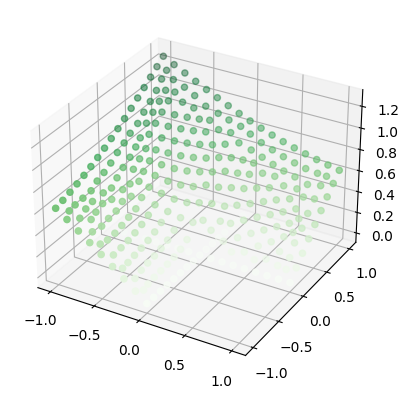

In [18]:
#Mark the boundary
domain_mark = mesh.domain_mark
bdry_mark = mesh.bdry_mark
print(mesh.crd[domain_mark].shape)
print(update_lhs.shape)
lhs = update_lhs[np.ix_(domain_mark,domain_mark)]

B = update_lhs[np.ix_(domain_mark,bdry_mark)]
#g_val = g(mesh.crd[bdry_mark][:,0],mesh.crd[bdry_mark][:,1]).reshape(-1,1)
g_val = gtgen.generate_by_cart(gtgen.bdry,mesh.crd[bdry_mark]).reshape(-1,1)
print(B.shape,g_val.shape,"!!")

rhs = update_rhs[domain_mark] - np.matmul(B,g_val)

print(lhs.shape)
#rhs = update_rhs[domain_mark]
print(rhs.shape)
#print("non-zero elements in matrix:",update_lhs[np.logical_not(update_lhs==0)].shape[0])
#Solve the linear system
sol_u_int = np.linalg.solve(lhs,rhs)
sol_u = np.zeros([len(mesh.crd),1])
sol_u[domain_mark] = sol_u_int
sol_u[bdry_mark] = g_val
#Plot the figure
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(mesh.crd[:,0], mesh.crd[:,1], sol_u, c=sol_u, cmap='Greens')
plt.show()

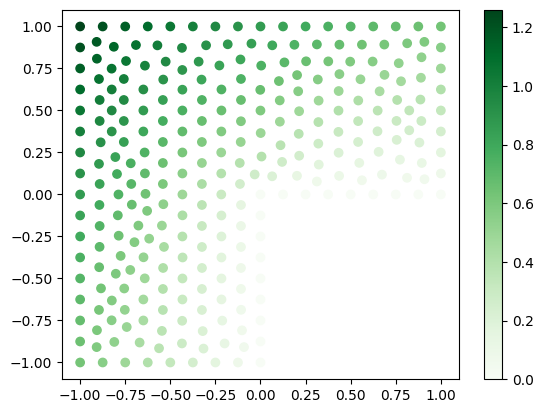

In [19]:
plt.scatter(mesh.crd[domain_mark+bdry_mark][:,0],mesh.crd[domain_mark+bdry_mark][:,1],c=sol_u[domain_mark+bdry_mark],cmap='Greens')
#plt.scatter(mesh.crd[bdry_mark][:,0],mesh.crd[bdry_mark][:,1],c=sol_u[bdry_mark],cmap='Greens')
plt.colorbar()

In [20]:
ygt = gtgen.generate_by_cart(gtgen.y,mesh.crd[domain_mark+bdry_mark])

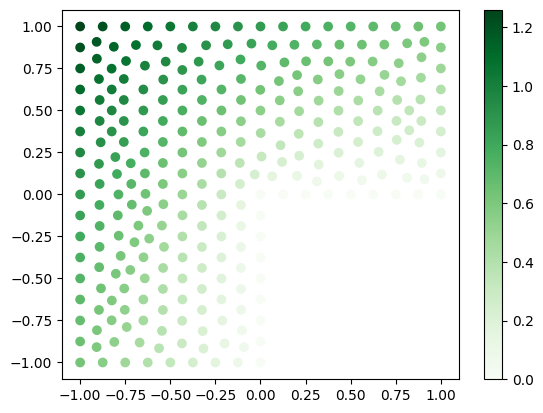

In [21]:
plt.scatter(mesh.crd[domain_mark+bdry_mark][:,0],mesh.crd[domain_mark+bdry_mark][:,1],c=ygt,cmap='Greens')
#plt.scatter(mesh.crd[bdry_mark][:,0],mesh.crd[bdry_mark][:,1],c=sol_u[bdry_mark],cmap='Greens')
plt.colorbar()

In [22]:
def clean_node_identify():
    flags = np.zeros([len(mesh.crd),1])
    for i in range(mesh.nrElem):
        flags[mesh.em[i,:]] = 1

    return flags

In [23]:
flags = clean_node_identify()

In [24]:
flags[flags<0.5]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [25]:
np.where(flags<0.5)[0]

array([64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77])

In [26]:
import pickle as pkl
with open("dataset/2000pts",'rb') as pfile:
    int_col = pkl.load(pfile)
    bdry_col = pkl.load(pfile)

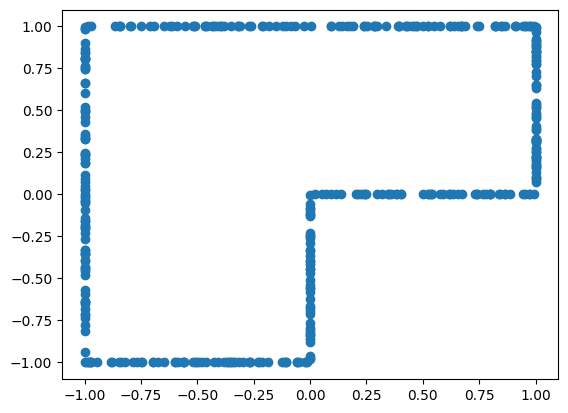

In [27]:
plt.scatter(bdry_col[:,0],bdry_col[:,1])

In [28]:
with open("dataset/gt_on_{}".format('2000pts'),'rb') as pfile:
    y_gt = pkl.load(pfile)
    f_np = pkl.load(pfile)
    bdry_np = pkl.load(pfile)


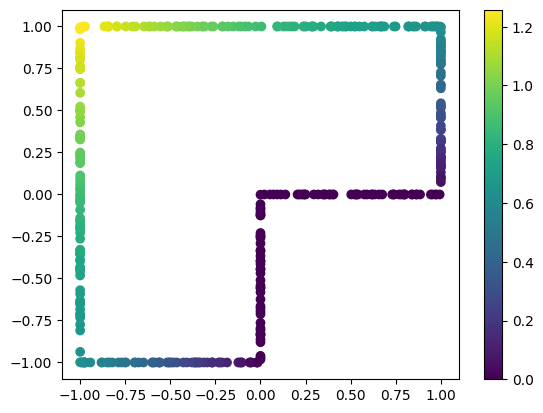

In [29]:
plt.scatter(bdry_col[:,0],bdry_col[:,1],c=bdry_np)
plt.colorbar()